In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('KDDTrain+.txt')
data.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [3]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted'
,'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate'
,'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

data.columns = columns
data = data.drop('level', axis=1)
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune
2,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune


In [4]:
data.attack.unique()
# data.attack = np.where(data.attack != "normal", 'malicious','normal')
# data.head()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [5]:
# changing attack labels to their respective attack class
def change_label(df):
  df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
  df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [6]:
change_label(data)
data.attack.unique()


array(['normal', 'Dos', 'R2L', 'Probe', 'U2R'], dtype=object)

In [7]:
data.isnull().values.any()

False

In [8]:
le = LabelEncoder()

data['protocol_type']=le.fit_transform(data['protocol_type'])
data['service']=le.fit_transform(data['service'])
data['flag']=le.fit_transform(data['flag'])
data['attack']=le.fit_transform(data['attack'])

In [9]:
x = data.drop('attack', axis=1)
y = data['attack']

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x)

In [10]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
# Reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [12]:
y_train = to_categorical(y_train,5)
y_test = to_categorical(y_test,5)

In [13]:
# the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(GRU(units=30))
model.add(Dense(units=5,activation='softmax'))


In [14]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Fit the model to the training data
model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/50
788/788 [==============================] - 9s 6ms/step - loss: 0.2341 - accuracy: 0.9364 - val_loss: 0.0965 - val_accuracy: 0.9680
Epoch 2/50
788/788 [==============================] - 4s 5ms/step - loss: 0.0762 - accuracy: 0.9746 - val_loss: 0.0700 - val_accuracy: 0.9762
Epoch 3/50
788/788 [==============================] - 4s 5ms/step - loss: 0.0587 - accuracy: 0.9803 - val_loss: 0.0534 - val_accuracy: 0.9810
Epoch 4/50
788/788 [==============================] - 4s 5ms/step - loss: 0.0493 - accuracy: 0.9840 - val_loss: 0.0472 - val_accuracy: 0.9843
Epoch 5/50
788/788 [==============================] - 4s 5ms/step - loss: 0.0426 - accuracy: 0.9863 - val_loss: 0.0401 - val_accuracy: 0.9874
Epoch 6/50
788/788 [==============================] - 4s 6ms/step - loss: 0.0373 - accuracy: 0.9886 - val_loss: 0.0371 - val_accuracy: 0.9879
Epoch 7/50
788/788 [==============================] - 5s 6ms/step - loss: 0.0340 - accuracy: 0.9896 - val_loss: 0.0388 - val_accuracy: 0.9865
Epoch 

In [16]:
# Model Evaluate
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Model Loss: {loss}\nModel Accuracy: {accuracy*100}")

788/788 [==============================] - 2s 3ms/step - loss: 0.0166 - accuracy: 0.9958
Model Loss: 0.01656319573521614
Model Accuracy: 99.58325028419495


In [17]:
y_predict=model.predict(x_test)

y_pred_classes = y_predict.argmax(axis=-1)
y_test_classes = y_test.argmax(axis=-1)

# classification report
report = classification_report(y_test_classes, y_pred_classes)
print(report)

788/788 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9224
           1       0.99      0.99      0.99      2373
           2       0.97      0.82      0.89       199
           3       0.86      0.46      0.60        13
           4       0.99      1.00      1.00     13386

    accuracy                           1.00     25195
   macro avg       0.96      0.85      0.90     25195
weighted avg       1.00      1.00      1.00     25195



ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (10).

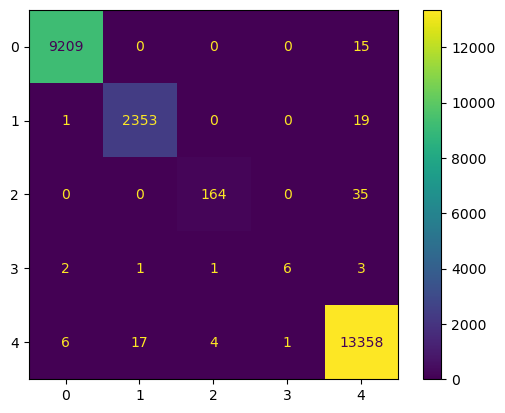

In [18]:
# import the confusion matrix function and class
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# compute the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# create a ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# plot the confusion matrix
cm_display.plot()
plt.show()

In [20]:
model.save("gru_kdd_data.h5")